In [1]:
# Install necessary libraries
!pip install apyori
!pip install yellowbrick
!pip install apyori mlxtend
!pip install catboost
!pip install scikit-learn
!pip install scikit-learn-extra

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, mean_squared_error, 
                             roc_auc_score, r2_score, silhouette_score)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, AgglomerativeClustering
from apyori import apriori as apyori_apriori
from scipy.cluster.hierarchy import dendrogram
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import os

# Enable inline plotting
%matplotlib inline


  Using cached scikit-learn-extra-0.3.0.tar.gz (818 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-win_amd64.whl size=402329 sha256=f1dd98b11c79a78b69f9df67906a17992a6914a0a8ec4414532cf78dfc12f3cd
  Stored in directory: c:\users\omart\appdata\local\pip\cache\wheels\17\4d\c3\c6d5d563c1bf8146d059d63be3678abc2f2801fba0aaf5f0b8
Successfully built scikit-learn-extra


In [2]:
# Load dataset
def load_data(filepath):
    """
    [10%] Display and interpret basic statistics for all attributes
    """
    data = pd.read_csv(filepath)
    print("Data Shape:", data.shape)
    print("First 5 Rows:\n", data.head())
    print("Data Info:\n", data.info())
    print("Missing Values:\n", data.isnull().sum())
    return data

# Load the data
file_path = "Census.csv" 
Census = load_data(file_path)


Data Shape: (569740, 22)
First 5 Rows:
    Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  Person ID     Region  \
0             0             0           0        333  E12000001   
1             1             1           1        349  E12000001   
2             2             2           2        236  E12000001   
3             3             3           3        357  E12000001   
4             4             4           4        228  E12000001   

  Residence Type  Family Composition  Population Base  Sex  Age  ...  \
0              H                   2                0    1    5  ...   
1              H                   3                0    1    0  ...   
2              H                   2                0    0    6  ...   
3              H                   1                0    1    5  ...   
4              H                   2                0    0    0  ...   

   Country of Birth  Health  Ethnic Group  Religion  Economic Activity  \
0                 1       2             1         

In [3]:
# Preprocess dataset
def preprocess_data(data):
    
    """
    Fill missing values, encode categorical columns, and normalize numeric columns.
    """
    
    # Handling the missing values
    for col in data.select_dtypes(include=["object"]).columns:
        data[col].fillna(data[col].mode()[0], inplace=True)
    for col in data.select_dtypes(include=["float64", "int64"]).columns:
        data[col].fillna(data[col].mean(), inplace=True)
    
    # Label encoding for categorical variables
    label_encoders = {}
    for col in data.select_dtypes(include=["object"]).columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

    # Normalizing the numeric columns
    scaler = MinMaxScaler()
    numeric_cols = data.select_dtypes(include=["float64", "int64"]).columns
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
    return data, label_encoders

# Preprocess the data
Census, label_encoders = preprocess_data(Census)
print("Data After Preprocessing:\n", Census.head())



C:\Users\omart\AppData\Local\Temp\ipykernel_17072\2616256862.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)
C:\Users\omart\AppData\Local\Temp\ipykernel_17072\2616256862.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

Data After Preprocessing:
    Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  Person ID  Region  Residence Type  \
0      0.000000      0.000000    0.000000   0.000584       0               1   
1      0.000002      0.000002    0.000002   0.000613       0               1   
2      0.000004      0.000004    0.000004   0.000414       0               1   
3      0.000005      0.000005    0.000005   0.000627       0               1   
4      0.000007      0.000007    0.000007   0.000400       0               1   

   Family Composition  Population Base  Sex       Age  ...  Country of Birth  \
0            0.333333              0.0  1.0  0.714286  ...               0.5   
1            0.500000              0.0  1.0  0.000000  ...               0.5   
2            0.333333              0.0  0.0  0.857143  ...               0.5   
3            0.166667              0.0  1.0  0.714286  ...               0.5   
4            0.333333              0.0  0.0  0.000000  ...               0.5   

   Health  

Basic Statistics:
         Unnamed: 0.2   Unnamed: 0.1     Unnamed: 0      Person ID  \
count  569740.000000  569740.000000  569740.000000  569740.000000   
mean        0.500000       0.500000       0.500000       0.500000   
std         0.288676       0.288676       0.288676       0.288676   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.250000       0.250000       0.250000       0.250000   
50%         0.500000       0.500000       0.500000       0.500000   
75%         0.750000       0.750000       0.750000       0.750000   
max         1.000000       1.000000       1.000000       1.000000   

              Region  Residence Type  Family Composition  Population Base  \
count  569740.000000   569740.000000       569740.000000    569740.000000   
mean        4.681671        0.981300            0.384942         0.009366   
std         2.609862        0.135463            0.210618         0.079529   
min         0.000000        0.000000            0.0

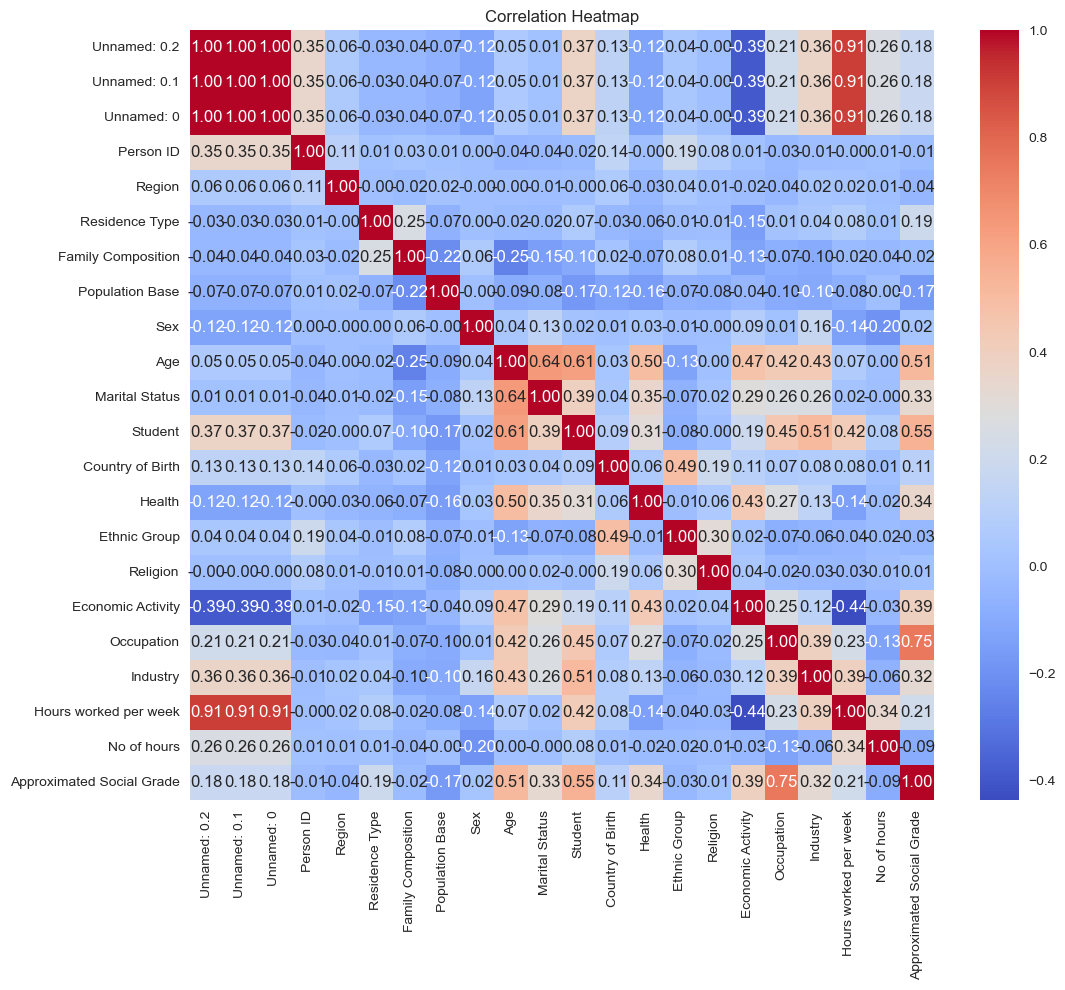


Histograms:


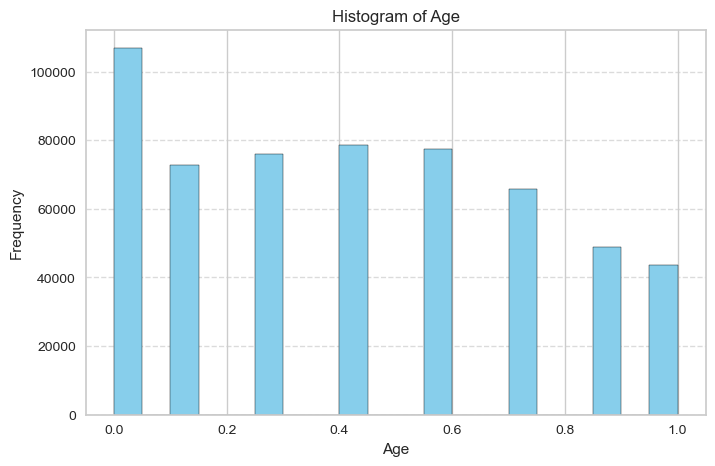


Box Plot:


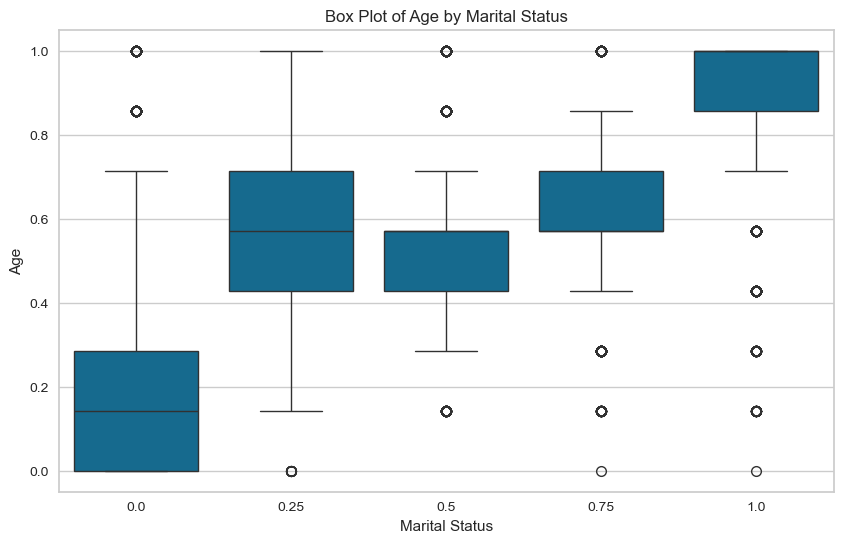


Pair Plot:


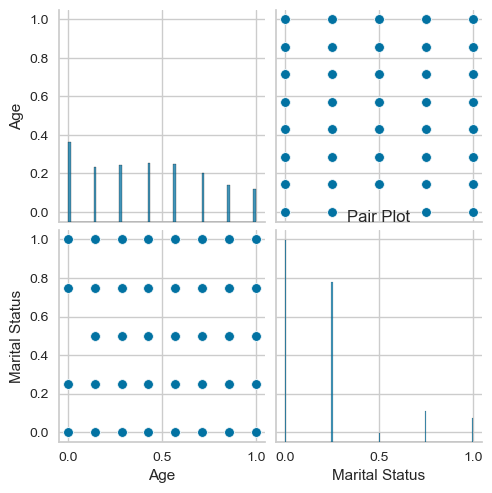


Scatter Plot:


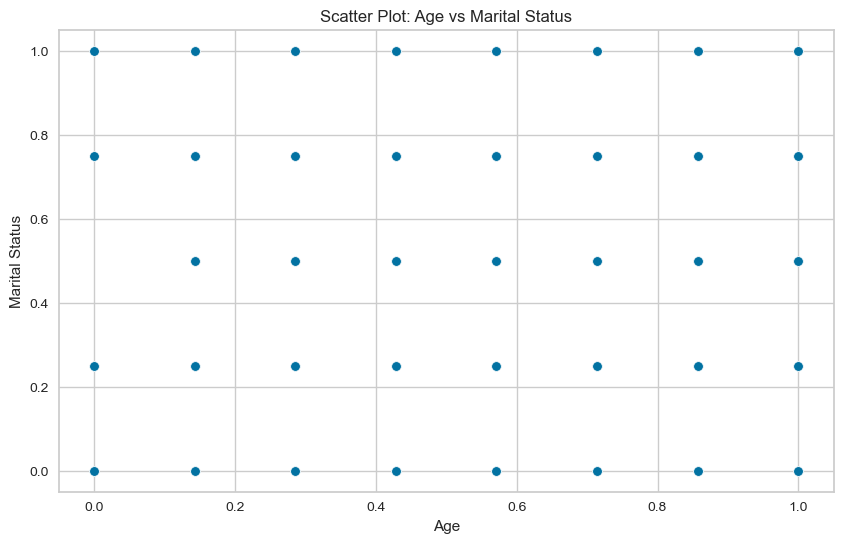


Bar Plot:


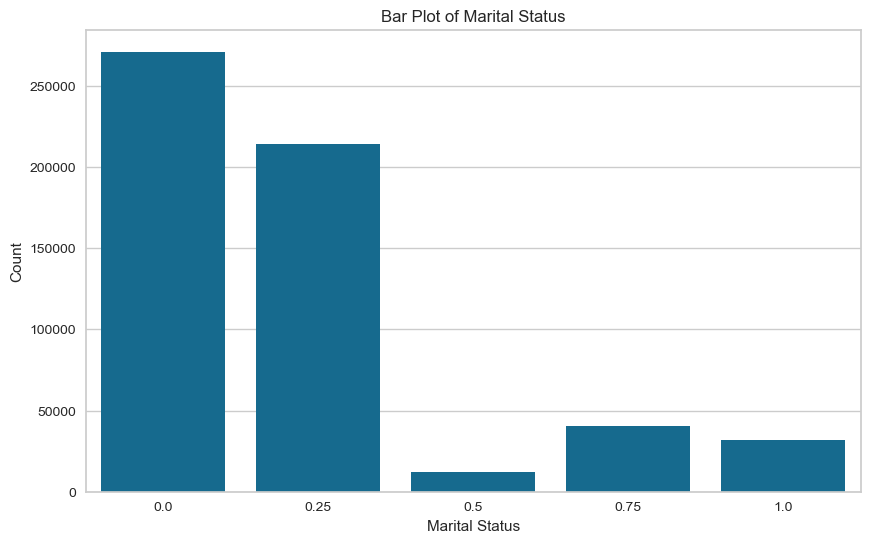


Violin Plot:


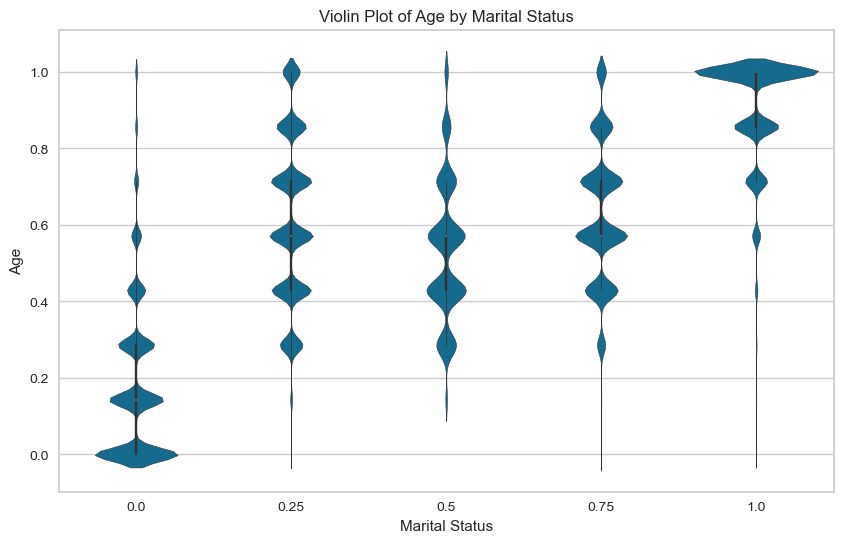

In [10]:
def descriptive_analytics(data):
    """
    Perform descriptive analytics with updated visualizations.
    """
    print("Basic Statistics:\n", data.describe())
    print("\nCorrelation Heatmap:")
    plot_correlations(data)
    print("\nHistograms:")
    plot_histograms(data, ["Age"])  # Focus on "Age" attribute
    print("\nBox Plot:")
    plot_box_plot(data, "Age", "Marital Status")  # Box plot for "Age" vs "Marital Status"
    print("\nPair Plot:")
    plot_pair_plot(data, ["Age", "Marital Status"])  # Pair plot of "Age" vs "Marital Status"
    print("\nScatter Plot:")
    plot_scatter_plot(data, "Age", "Marital Status")  # Scatter plot of "Age" vs "Marital Status"
    print("\nBar Plot:")
    plot_bar_plot(data, "Marital Status")  # Bar plot of "Marital Status"
    print("\nViolin Plot:")
    plot_violin_plot(data, "Age", "Marital Status")  # New Violin plot



def plot_correlations(data):
    """Plots a heatmap of correlations for numeric columns."""
    correlation_matrix = data.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Heatmap")
    plt.show()


def plot_histograms(data, columns):
    """Plots histograms for the specified columns in the dataset."""
    for column in columns:
        if column in data.columns:
            plt.figure(figsize=(8, 5))
            plt.hist(data[column], bins=20, color="skyblue", edgecolor="black")
            plt.title(f"Histogram of {column}")
            plt.xlabel(column)
            plt.ylabel("Frequency")
            plt.grid(axis="y", linestyle="--", alpha=0.7)
            plt.show()
        else:
            print(f"Column '{column}' not found in the dataset.")


def plot_box_plot(data, x, y):
    """
    Plot a box plot for two attributes.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[y], y=data[x])
    plt.title(f"Box Plot of {x} by {y}")
    plt.xlabel(y)
    plt.ylabel(x)
    plt.show()

def plot_pair_plot(data, columns):
    """
    Plot a pairplot for selected columns.
    """
    sns.pairplot(data[columns])
    plt.title("Pair Plot")
    plt.show()

def plot_scatter_plot(data, x, y):
    """
    Plot a scatter plot for two attributes.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data[x], y=data[y])
    plt.title(f"Scatter Plot: {x} vs {y}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

def plot_bar_plot(data, column):
    """
    Plot a bar plot showing value counts for a categorical column.
    """
    value_counts = data[column].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f"Bar Plot of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

def plot_violin_plot(data, x, y):
    """
    Plot a violin plot for the distribution of a numerical attribute grouped by a categorical attribute.
    """
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=data[y], y=data[x])
    plt.title(f"Violin Plot of {x} by {y}")
    plt.xlabel(y)
    plt.ylabel(x)
    plt.show()

# Perform descriptive analytics
descriptive_analytics(Census)


Decision Tree - Accuracy: 0.8062484642117457
Random Forest - Accuracy: 0.8450100045634851
KNN - Accuracy: 0.7805033875100923
CatBoost - Accuracy: 0.8553796468564608

Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.93      0.93      0.93     35757
           1       0.78      0.78      0.78     35504
           2       0.73      0.73      0.73     35791
           3       0.79      0.78      0.79     35383

    accuracy                           0.81    142435
   macro avg       0.81      0.81      0.81    142435
weighted avg       0.81      0.81      0.81    142435

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.95      0.94      0.94     35757
           1       0.83      0.82      0.83     35504
           2       0.80      0.76      0.78     35791
           3       0.80      0.86      0.83     35383

    accuracy                           0.85    

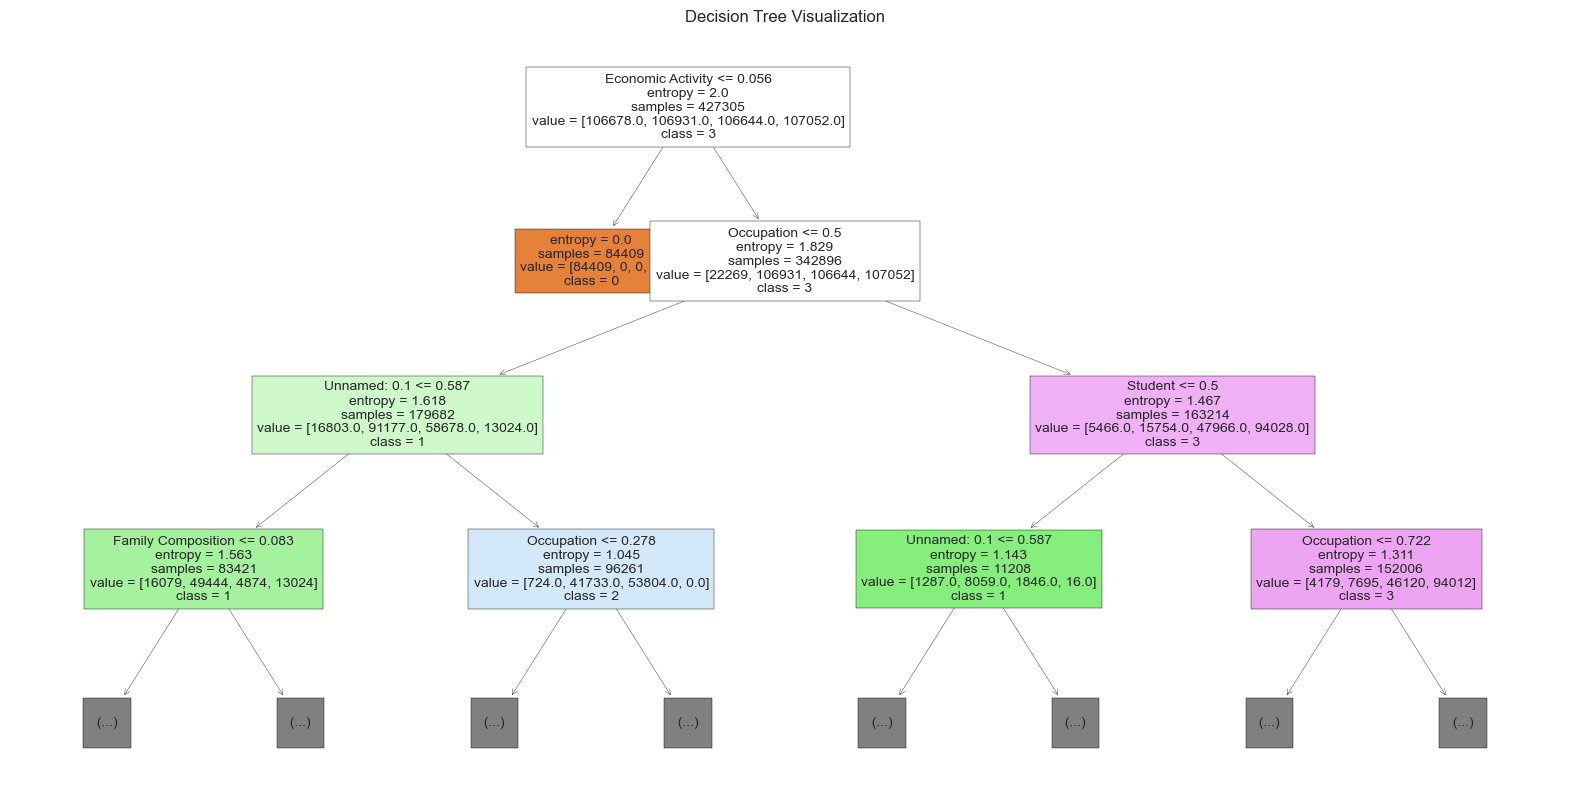

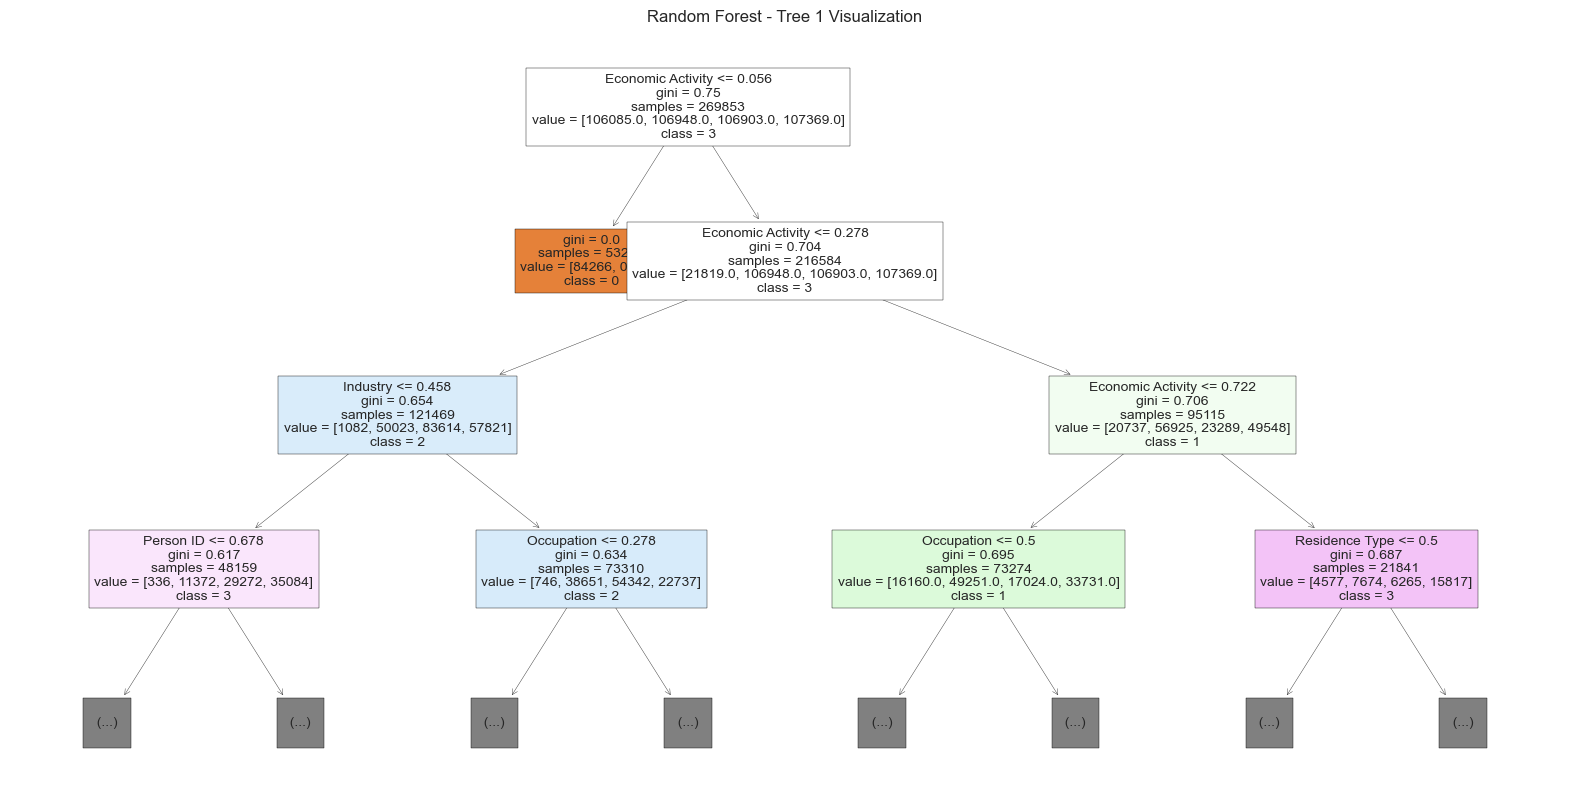

KNN does not have a tree structure. No tree visualization is possible.
CatBoost does not have a tree structure. No tree visualization is possible.


In [31]:
# Classification

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Using binning to convert the target 'Approximated Social Grade' to categorical
Census['Approximated Social Grade'] = pd.qcut(
    Census['Approximated Social Grade'].rank(method="first"), 
    q=4, 
    labels=[0, 1, 2, 3]
)

# Defining features (X) and target (y)
X = Census.iloc[:, :-1].values  # Features (excluding target column)
y = Census.iloc[:, -1].values   # Target (now categorical)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Ensure target variable is in the correct type (integer or string for CatBoost)
y_train = y_train.astype(str)  # Convert to string (if needed) for CatBoost
y_test = y_test.astype(str)    # Consistent conversion for CatBoost

# Decision Tree Classification
DT = DecisionTreeClassifier(criterion="entropy", random_state=42)
DT.fit(X_train, y_train)
y_pred_DT = DT.predict(X_test)

# Random Forest Classification
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_test)

# KNN Classification
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train, y_train)
y_pred_KNN = KNN.predict(X_test)

# CatBoost Classification
catboost_clf = CatBoostClassifier(verbose=0, iterations=500, random_state=42)
catboost_clf.fit(X_train, y_train)
y_pred_CB = catboost_clf.predict(X_test)

# Classification Metrics for all models
print("Decision Tree - Accuracy:", accuracy_score(y_test, y_pred_DT))
print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred_RF))
print("KNN - Accuracy:", accuracy_score(y_test, y_pred_KNN))
print("CatBoost - Accuracy:", accuracy_score(y_test, y_pred_CB))

# Classification Reports
print("\nClassification Report (Decision Tree):\n", classification_report(y_test, y_pred_DT))
print("Classification Report (Random Forest):\n", classification_report(y_test, y_pred_RF))
print("Classification Report (KNN):\n", classification_report(y_test, y_pred_KNN))
print("Classification Report (CatBoost):\n", classification_report(y_test, y_pred_CB))

# Visualize the Decision Tree with limited depth
plt.figure(figsize=(20, 10))
plot_tree(
    DT, 
    filled=True, 
    feature_names=Census.columns[:-1],  # Features (excluding target)
    class_names=['0', '1', '2', '3'],  # Classes (Approximated Social Grade categories)
    fontsize=10, 
    max_depth=3  # Limit the depth of the tree
)
plt.title("Decision Tree Visualization")
plt.show()

# Random Forest Visualization (Tree View for First Estimator)
plt.figure(figsize=(20, 10))
plot_tree(
    RF.estimators_[0],
    filled=True,
    feature_names=Census.columns[:-1],
    class_names=['0', '1', '2', '3'],
    fontsize=10,
    max_depth=3
)
plt.title("Random Forest - Tree 1 Visualization")
plt.show()

# KNN Visualization (Alternative)
print("KNN does not have a tree structure. No tree visualization is possible.")

# CatBoost Visualization (Alternative)
print("CatBoost does not have a tree structure. No tree visualization is possible.")


In [13]:
# Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Ensure that the target variables are numeric (regardless of initial format)
y_train = pd.to_numeric(y_train, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

# Linear Regression
LR = LinearRegression()
LR.fit(X_train, y_train)
y_pred_reg = LR.predict(X_test)

# Random Forest Regression
RF_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
RF_regressor.fit(X_train, y_train)
y_pred_RF_reg = RF_regressor.predict(X_test)

# CatBoost Regression
catboost_regressor = CatBoostRegressor(verbose=0, iterations=500, random_state=42)
catboost_regressor.fit(X_train, y_train)
y_pred_cb_reg = catboost_regressor.predict(X_test)

# Regression Metrics for all models
print('Linear Regression - Mean Squared Error:', mean_squared_error(y_test, y_pred_reg))
print('Random Forest Regression - Mean Squared Error:', mean_squared_error(y_test, y_pred_RF_reg))
print('CatBoost Regression - Mean Squared Error:', mean_squared_error(y_test, y_pred_cb_reg))

print('Linear Regression - R2 Score:', r2_score(y_test, y_pred_reg))
print('Random Forest Regression - R2 Score:', r2_score(y_test, y_pred_RF_reg))
print('CatBoost Regression - R2 Score:', r2_score(y_test, y_pred_cb_reg))

# Adjusted R2 for Random Forest and CatBoost
n = X_test.shape[0]
p = X_test.shape[1]
adj_r2_rf = 1 - (1 - r2_score(y_test, y_pred_RF_reg)) * (n - 1) / (n - p - 1)
adj_r2_cb = 1 - (1 - r2_score(y_test, y_pred_cb_reg)) * (n - 1) / (n - p - 1)

print("Adjusted R2 for Random Forest Regression:", adj_r2_rf)
print("Adjusted R2 for CatBoost Regression:", adj_r2_cb)


Linear Regression - Mean Squared Error: 0.40487574145563
Random Forest Regression - Mean Squared Error: 0.2145356583704848
CatBoost Regression - Mean Squared Error: 0.19783737358511272
Linear Regression - R2 Score: 0.6758149519915438
Random Forest Regression - R2 Score: 0.8282207463002986
CatBoost Regression - R2 Score: 0.8415911058959178
Adjusted R2 for Random Forest Regression: 0.8281954159980952
Adjusted R2 for CatBoost Regression: 0.8415677471661938


In [14]:
# Association rule mining
from apyori import apriori
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

# Simulate the Census data with some of the columns mentioned in your guide
# (Replace this with your actual DataFrame)
census = pd.DataFrame({
    'Family composition': [1, 2, 3, 4, 5, -9, 6],
    'Population base': [1, 2, 3, 1, 2, 3, 1],
    'Sex': [1, 2, 1, 2, 1, 1, 2],
    'Age': [25, 34, 16, 45, 60, 12, 80],
    'Marital status': [1, 2, 3, 4, 5, -9, 1],
    'Student': [1, 2, 1, 2, 1, 1, 2],
    'Country of birth': [1, 2, 1, 1, 2, 1, 1],
    'Health': [1, 2, 3, 4, 5, -9, 1],
    'Ethnic group': [1, 2, 3, 4, 5, -9, 1],
    'Religion': [1, 2, 3, 4, 5, 6, 7],
    'Economic activity': [1, 2, 3, 4, 5, 6, 7],
    'Occupation': [1, 2, 3, 4, 5, 6, 7],
    'Industry': [1, 2, 3, 4, 5, 6, 7],
    'Hours worked per week': [1, 2, 3, 4, -9, 1, 3],
    'Social grade': [1, 2, 3, 4, -9, 1, 2]
})

# Replace categorical values with their respective labels
census['Family composition'] = census['Family composition'].replace([1, 2, 3, 4, 5, -9, 6],
                                     ['Not in a family', 'Married/civil partnership', 'Cohabiting couple',
                                      'Lone parent (male)', 'Lone parent (female)', 'No code required', 'Other related family'])

census['Sex'] = census['Sex'].replace([1, 2], ['Male', 'Female'])

census['Age'] = pd.cut(census['Age'], bins=[0, 15, 24, 34, 44, 54, 64, 74, 100], labels=['0-15', '16-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+'])

census['Marital status'] = census['Marital status'].replace([1, 2, 3, 4, 5], ['Single', 'Married', 'Separated', 'Divorced', 'Widowed'])

census['Student'] = census['Student'].replace([1, 2], ['Yes', 'No'])

census['Country of birth'] = census['Country of birth'].replace([1, 2], ['UK', 'Non-UK'])

census['Health'] = census['Health'].replace([1, 2, 3, 4, 5], ['Very good health', 'Good health', 'Fair health', 'Bad health', 'Very bad health'])

census['Ethnic group'] = census['Ethnic group'].replace([1, 2, 3, 4, 5], ['White', 'Mixed', 'Asian', 'Black', 'Chinese or Other'])

census['Religion'] = census['Religion'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9], ['No religion', 'Christian', 'Buddhist', 'Hindu', 'Jewish', 'Muslim', 'Sikh', 'Other religion', 'Not stated'])

census['Economic activity'] = census['Economic activity'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9], ['Employee', 'Self-employed', 'Unemployed', 'Full-time student', 'Retired', 'Student', 'Looking after home', 'Long-term sick', 'Other'])

census['Occupation'] = census['Occupation'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9], ['Managers', 'Professionals', 'Technical occupations', 'Secretarial', 'Skilled trades', 'Leisure/service', 'Sales', 'Plant operatives', 'Elementary jobs'])

census['Industry'] = census['Industry'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['Agriculture', 'Mining/Manufacturing', 'Construction', 'Retail', 'Accommodation/Food', 'Transport/Storage', 'Finance', 'Real estate', 'Public sector', 'Education', 'Health', 'Other services'])

census['Hours worked per week'] = census['Hours worked per week'].replace([1, 2, 3, 4], ['Part-time: 15 or less', 'Part-time: 16-30', 'Full-time: 31-48', 'Full-time: 49+'])

census['Social grade'] = census['Social grade'].replace([1, 2, 3, 4], ['AB', 'C1', 'C2', 'DE'])

# Convert all columns to strings for association rule mining
census = census.astype(str)

# Convert data to list of lists for both Apriori and FP-Growth
data_list = census.values.tolist()

# Apriori Implementation
rules_apriori = apriori(data_list, min_support=0.25, min_confidence=0.25, min_length=2)
results_apriori = list(rules_apriori)

# Clean Apriori Results into a DataFrame
df_apriori = pd.DataFrame(columns=('Antecedent', 'Consequent', 'Support', 'Confidence', 'Lift'))

Support = []
Confidence = []
Lift = []
Antecedent = []
Consequent = []

for RelationRecord in results_apriori:
    for ordered_stat in RelationRecord.ordered_statistics:
        Support.append(RelationRecord.support)
        Antecedent.append(ordered_stat.items_base)
        Consequent.append(ordered_stat.items_add)
        Confidence.append(ordered_stat.confidence)
        Lift.append(ordered_stat.lift)

df_apriori['Antecedent'] = list(map(set, Antecedent))
df_apriori['Consequent'] = list(map(set, Consequent))
df_apriori['Support'] = Support
df_apriori['Confidence'] = Confidence
df_apriori['Lift'] = Lift
df_apriori.sort_values(by='Lift', ascending=False, inplace=True)

# FP-Growth Implementation
# Encode the data for FP-Growth
te = TransactionEncoder()
te_ary = te.fit(data_list).transform(data_list)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Find frequent itemsets using FP-Growth
frequent_itemsets_fp = fpgrowth(df_encoded, min_support=0.25, use_colnames=True)

# Derive rules using the frequent itemsets
rules_fp = association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=0.25, num_itemsets=5)  # Set the num_itemsets value

# Display the top rules from Apriori and FP-Growth
print("Top rules from Apriori:")
print(df_apriori.head())
print("\nTop rules from FP-Growth:")
print(rules_fp.sort_values(by='lift', ascending=False).head())


Top rules from Apriori:
                                 Antecedent                     Consequent  \
564  {Yes, Male, UK, Part-time: 15 or less}                           {AB}   
377                         {White, Single}          {Very good health, 1}   
420                                {AB, UK}  {Male, Part-time: 15 or less}   
418                              {Male, AB}    {UK, Part-time: 15 or less}   
416                 {Part-time: 15 or less}                 {AB, Male, UK}   

      Support  Confidence  Lift  
564  0.285714         1.0   3.5  
377  0.285714         1.0   3.5  
420  0.285714         1.0   3.5  
418  0.285714         1.0   3.5  
416  0.285714         1.0   3.5  

Top rules from FP-Growth:
                           antecedents                  consequents  \
308              (Very good health, 1)                 (UK, Single)   
122  (Male, UK, Part-time: 15 or less)                         (AB)   
124                         (AB, Male)  (UK, Part-time: 15 or l

KMeans Silhouette Score: 0.19062754364590656
Agglomerative Clustering Silhouette Score: 0.5534820015553282
KMedoids Silhouette Score: 0.05074744902217973
KMeans Silhouette Score after PCA: 0.44995697355992337
Agglomerative Clustering Silhouette Score after PCA: -0.039665483153874144
KMedoids Silhouette Score after PCA: 0.022635681403810195


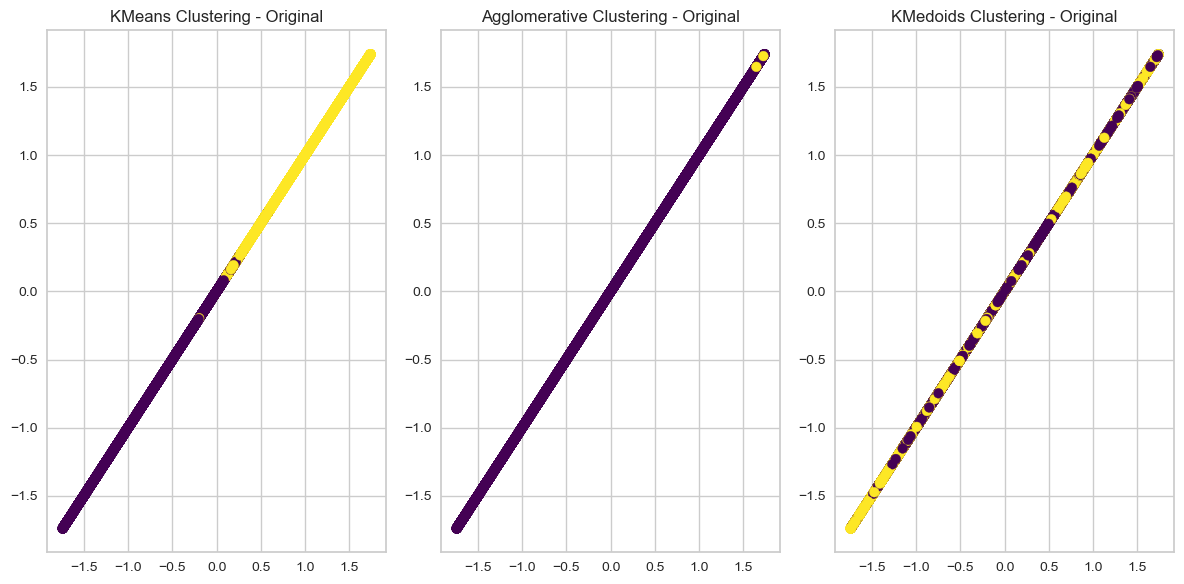

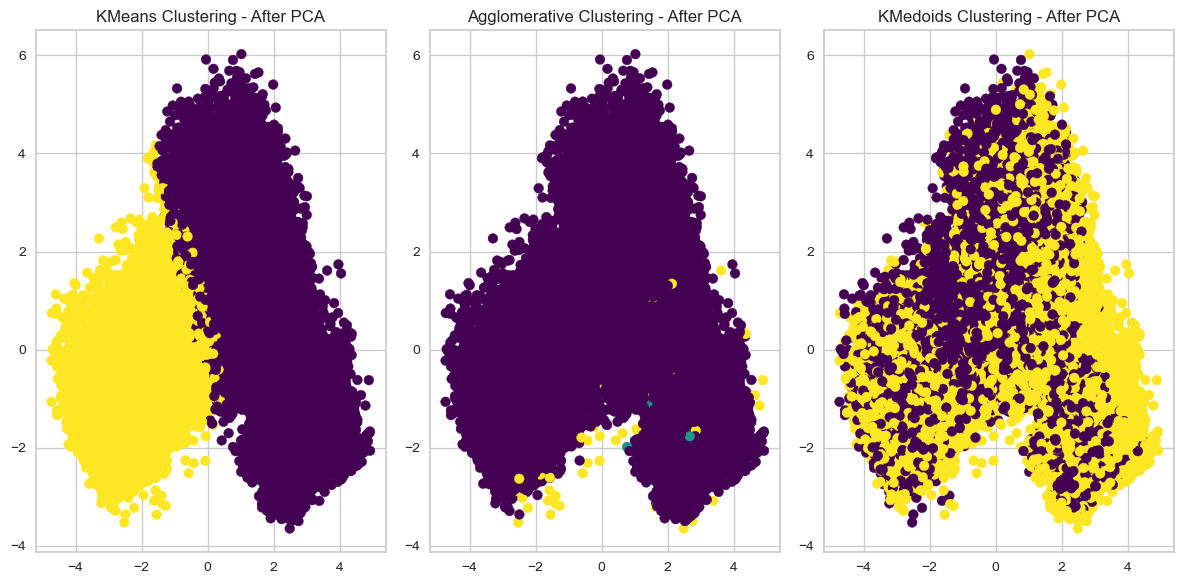

In [29]:
#Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn_extra.cluster import KMedoids  # Importing KMedoids
import matplotlib.pyplot as plt
import numpy as np
import os

Census_sample = Census.sample(frac=0.06, random_state=42)  # 10% of the data

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(Census_sample)

# KMeans Clustering with optimized parameters
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10, max_iter=300)
kmeans.fit(scaled_features)

# Agglomerative Clustering with different linkage method (Single or Complete linkage)
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='single')  # Using 'single' linkage
agg_labels = agg_clustering.fit_predict(scaled_features)

# K-Medoids Clustering
kmedoids = KMedoids(n_clusters=2, random_state=42, method='alternate')  # Using 'alternate' method
kmedoids.fit(scaled_features)

# Evaluate Clusters using Silhouette Score
print("KMeans Silhouette Score:", silhouette_score(scaled_features, kmeans.labels_))
print("Agglomerative Clustering Silhouette Score:", silhouette_score(scaled_features, agg_labels))
print("KMedoids Silhouette Score:", silhouette_score(scaled_features, kmedoids.labels_))

# Perform PCA to reduce dimensionality (further optimize for visualization)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Recalculate Silhouette Scores after PCA
print("KMeans Silhouette Score after PCA:", silhouette_score(pca_features, kmeans.labels_))
print("Agglomerative Clustering Silhouette Score after PCA:", silhouette_score(pca_features, agg_labels))
print("KMedoids Silhouette Score after PCA:", silhouette_score(pca_features, kmedoids.labels_))

# Visualize Clusters before and after PCA
plt.figure(figsize=(12, 6))

# Original Clusters
plt.subplot(1, 3, 1)
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=kmeans.labels_, cmap="viridis")
plt.title("KMeans Clustering - Original")

plt.subplot(1, 3, 2)
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=agg_labels, cmap="viridis")
plt.title("Agglomerative Clustering - Original")

plt.subplot(1, 3, 3)
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=kmedoids.labels_, cmap="viridis")
plt.title("KMedoids Clustering - Original")

plt.tight_layout()
plt.show()

# Visualize Clusters after PCA
plt.figure(figsize=(12, 6))

# KMeans after PCA
plt.subplot(1, 3, 1)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans.labels_, cmap="viridis")
plt.title("KMeans Clustering - After PCA")

# Agglomerative Clustering after PCA
plt.subplot(1, 3, 2)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=agg_labels, cmap="viridis")
plt.title("Agglomerative Clustering - After PCA")

# KMedoids after PCA
plt.subplot(1, 3, 3)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmedoids.labels_, cmap="viridis")
plt.title("KMedoids Clustering - After PCA")

plt.tight_layout()
plt.show()
